# **Using Draft Strategy to Predict Fantasy Points**

How accurately can we predict the number of points a Best Ball Mania entry will score based solely on the drafter's draft strategy? Thanks to machine learning and a data dump from Underdog Network, we have the tools to answer this question. Best Ball Mania is the best of competitive fantasy football; With the high level of competition, drafters are very meticulous when making their picks and deciding on their overall strategy.

Some things drafters may consider:

*   **Average Draft Position:** Usually referred to as ADP, this number represents what overall pick, on average, a player is being taken in fanatsy drafts at that current moment in time. Drafters may reach for a player they really like by taking them above ADP or snag a player who falls below their ADP.

*   **Stacking:** By taking multiple players from the same NFL team, a drafter has drafted what is called a stack. An example of this is drafting Tyreek Hill, Jaylen Waddle, and Tua Tagovailoa in the same lineup. The idea is to double-down on an offense that one thinks will perform well throughout the season (or in a particular game); If one player puts up a lot of fantasy points, there's a good chance their teammate will too. Of course, this strategy can backfire.

*   **Early Round RB Strategy:** Early round running backs are often risky picks, due to year-to-year volality, high injury rates, and the continously increasing number of running back by committees. But the upside is there. Competitive drafters will implement strategies such as "Zero RB" and "Hero RB" based on whether or not they land a star running back (or multiple star running backs) in the early rounds of fantasy drafts.

With these in mind, we will transform our dataset in preparation for the training and testing of an XGBoost model!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Firstly, we'll read the data from a CSV into a Pandas data frame. The dataset we'll be using was downloaded from: https://underdognetwork.com/football/best-ball-mania-ii-downloadable-pick-by-pick-data. The dataset includes every single pick that was made during Underdog's Best Ball Mania II contest during the 2021-2022 NFL season (1,497,536 picks in total). For each pick, we are provided following information:

*   ***draft id:*** The unique ID of the draft
*   ***draft_time:*** Date and time of the draft
*   ***clock:*** The time (in seconds) allowed for the pick
*   ***tournament_entry_id:*** The unique ID of the entry
*   ***tournament_round_number:*** The round number of the BBMII contest
*   ***player_name:*** Name of the player chosen
*   ***position_name:*** The player's position
*   ***bye_week:*** The player's bye week
*   ***projection_adp:*** The player's ADP (at the time of the draft)
*   ***pick_order:*** Position in the draft order (1-12)
*   ***overall_pick_number:*** Position in the overall draft (1-216)
*   ***pick_points:*** The number of points the player contributed to the entry
*   ***roster_points:*** The number of points scored by the entire entry
*   ***playoff_team:*** Whether or not the entry advanced to the next round

In [2]:
df = pd.read_csv('https://media.githubusercontent.com/media/jackspagna/predicting_fpts/main/BBM_II_Data_Dump_Regular_Season_01312022.csv')

df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team
0,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,e1fdb4f8-4da3-4a09-8e6c-ef294c053251,1,Jalen Reagor,WR,14,139.48,1,144,12,31.2,1613.92,0
1,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Marquez Callaway,WR,6,107.46,6,115,10,81.9,1525.06,0
2,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Amari Cooper,WR,7,31.75,6,30,3,116.3,1525.06,0
3,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Rhamondre Stevenson,RB,14,171.55,11,158,14,66.5,1669.72,1
4,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Darrynton Evans,RB,13,201.35,11,203,17,2.8,1669.72,1


With the data properly loaded, we'll now focus on analyzing where each entry drafted in relation to ADP. For starters, we will create a new column called *vs_adp* that measures where the player was taken compared to their ADP for each pick. *vs_adp* subtracts the player's ADP from the overall pick number they were taken at. Negative values mean that the player was taken ahead of their ADP, while positive values mean that the player was taken after their ADP. Some players taken in the late rounds have ADPs of either 0 or greater than 216.0. These indicate that the player was not drafted enough to yield an accurate ADP. Our new *vs_adp* column will produce an NA for these picks.

In [3]:
from pandas.core.arrays.interval import NA

df['vs_adp'] = np.where( (df['projection_adp'] > 1.0) & (df['projection_adp'] <= 216.0),
                         df['overall_pick_number'] - df['projection_adp'], pd.NA)

df.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,vs_adp
0,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,e1fdb4f8-4da3-4a09-8e6c-ef294c053251,1,Jalen Reagor,WR,14,139.48,1,144,12,31.2,1613.92,0,4.52
1,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Marquez Callaway,WR,6,107.46,6,115,10,81.9,1525.06,0,7.54
2,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Amari Cooper,WR,7,31.75,6,30,3,116.3,1525.06,0,-1.75
3,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Rhamondre Stevenson,RB,14,171.55,11,158,14,66.5,1669.72,1,-13.55
4,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Darrynton Evans,RB,13,201.35,11,203,17,2.8,1669.72,1,1.65


Now we can find the average value of *vs_adp* for each entry, representing how much the drafter either drafted above or below ADP throughout the entire draft.

In [4]:
adp_complete = df.dropna()

vs_adp_avg = pd.DataFrame( adp_complete.groupby('tournament_entry_id')['vs_adp'].mean() )

vs_adp_avg.head()

,vs_adp
tournament_entry_id,
00010ed4-3be2-47e7-b771-7d0ee3cf093e,-1.528333
00014287-2cbf-40d6-aed5-ce5925789aad,2.229444
0001f38b-c1ee-4cde-8e32-de0f8ed94c1e,0.882778
00022606-02af-42a0-90a8-70cace432a23,-4.010556
0002963d-f0e6-45f0-b8e7-b3f39bf747ef,4.140000


Next we want to determine how each entry utilized stacking. Since the player's NFL team is not included in our dataset, we'll have to merge our dataset with another that contains this information.

In [6]:
players = pd.read_csv('https://media.githubusercontent.com/media/jackspagna/predicting_fpts/main/2021players.csv')

players.head()

,Player,Tm
0,Jonathan Taylor,IND
1,Cooper Kupp,LAR
2,Deebo Samuel,SFO
3,Josh Allen,BUF
4,Austin Ekeler,LAC


The "2021players.csv" file contains every player who was active during the 2021 NFL season and the team that they played for that season. It is a modified version of the Pro-Football-Reference 2021 NFL Fantasy Rankings page found here: https://www.pro-football-reference.com/years/2021/fantasy.htm. A few changes and additions to the data were made manually to make sure our data is accurate and inclusive of every player drafted in Best Ball Mania II.

In [8]:
df_teams = df.merge(players, how='left', left_on='player_name', right_on='Player')

df_teams.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,vs_adp,Player,Tm
0,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,e1fdb4f8-4da3-4a09-8e6c-ef294c053251,1,Jalen Reagor,WR,14,139.48,1,144,12,31.2,1613.92,0,4.52,Jalen Reagor,PHI
1,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Marquez Callaway,WR,6,107.46,6,115,10,81.9,1525.06,0,7.54,Marquez Callaway,NOR
2,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,b1e60f0c-2982-4e5c-8f80-da9a104cb290,1,Amari Cooper,WR,7,31.75,6,30,3,116.3,1525.06,0,-1.75,Amari Cooper,DAL
3,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Rhamondre Stevenson,RB,14,171.55,11,158,14,66.5,1669.72,1,-13.55,Rhamondre Stevenson,NWE
4,00009a0e-b1a6-42e0-b1cf-3f884cc0999b,2021-08-28 17:06:42.031664+00:00,30,5388d065-c260-45cc-b9bf-fcb37f767d2c,1,Darrynton Evans,RB,13,201.35,11,203,17,2.8,1669.72,1,1.65,Darrynton Evans,TEN


With the datasets merged, we'll now break down how many players from each NFL team every entry has.

In [9]:
team_counts = pd.DataFrame( df_teams.groupby(['tournament_entry_id', 'Tm'])['Tm'].count() )

team_counts.columns = ['players']

team_counts.head()

players
tournament_entry_id                  Tm          
00010ed4-3be2-47e7-b771-7d0ee3cf093e ARI        1
                                     BUF        2
                                     CAR        1
                                     CIN        1
                                     DAL        2

Since we are only concerned with stacks (2 or more players on the same team), we will filter out any team counts that are less than or equal to 1.

In [10]:
stacks_df = team_counts[team_counts.players > 1].reset_index()

stacks_df.head()

,tournament_entry_id,Tm,players
0,00010ed4-3be2-47e7-b771-7d0ee3cf093e,BUF,2
1,00010ed4-3be2-47e7-b771-7d0ee3cf093e,DAL,2
2,00010ed4-3be2-47e7-b771-7d0ee3cf093e,IND,2
3,00010ed4-3be2-47e7-b771-7d0ee3cf093e,LVR,2
4,00010ed4-3be2-47e7-b771-7d0ee3cf093e,NOR,2


By grouping by entry and taking the sum of the *players* column, we can determine how many stacked players each entry has. The number of stacked players was used instead of number of stacks to account for potential stacks of more than 2 players.

In [11]:
stacked_players = pd.DataFrame( stacks_df.groupby(['tournament_entry_id'])['players'].sum() )
stacked_players.columns = ['stacked_players']

stacked_players = stacked_players.reset_index()

stacked_players.head()

,tournament_entry_id,stacked_players
0,00010ed4-3be2-47e7-b771-7d0ee3cf093e,10
1,00014287-2cbf-40d6-aed5-ce5925789aad,7
2,0001f38b-c1ee-4cde-8e32-de0f8ed94c1e,4
3,00022606-02af-42a0-90a8-70cace432a23,8
4,0002963d-f0e6-45f0-b8e7-b3f39bf747ef,7


We're not done with stacks yet though, as there may be some entries with 0 stacks. To get these entries, we need to find every entry that exists in our original data frame but not the data frame of all stacked entries. We'll create a data frame of these non-stacked entries. Then, we'll create a *stacked_players* column with a corresponding value of 0.

In [12]:
all_entries = pd.DataFrame(df.tournament_entry_id.unique() )
all_entries.columns = ['tournament_entry_id']

stacked_entries = stacked_players.tournament_entry_id.values.tolist()

non_stacked_entries = pd.DataFrame()
non_stacked_entries = all_entries[~all_entries.tournament_entry_id.isin(stacked_entries)]

non_stacked_entries['stacked_players'] = 0

non_stacked_entries.head()

<ipython-input-12-1feca297cfab>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_stacked_entries['stacked_players'] = 0


,tournament_entry_id,stacked_players
820,c25d4a1e-82cb-487a-bb3f-89c1cc25b45c,0
5594,fda2cfd8-d79a-49b6-8749-4b03e52d41ac,0
5877,1474de37-946f-4fd2-a919-c46e972cba24,0
7211,f81500f9-1a9a-428a-ad09-b82082a8e85d,0
9462,d3ebecad-1c2b-4367-ac87-c7ebe5a93501,0


Finally, we can concatenate our stacked data frame and non-stacked data frame to give us the number of stacked players from all entries.

In [13]:
stacked_players = pd.concat([stacked_players, non_stacked_entries])

stacked_players.head()

,tournament_entry_id,stacked_players
0,00010ed4-3be2-47e7-b771-7d0ee3cf093e,10
1,00014287-2cbf-40d6-aed5-ce5925789aad,7
2,0001f38b-c1ee-4cde-8e32-de0f8ed94c1e,4
3,00022606-02af-42a0-90a8-70cace432a23,8
4,0002963d-f0e6-45f0-b8e7-b3f39bf747ef,7


Now we want to determine which early round RB strategy, if any, a drafter used with their entry. Though these strategies have somewhat flexible defintions, we will be using the following strategies with definitions as follows:

*   **Zero RB:** No RBs taken in rounds 1-5
*   **Hero RB:** 1 RB taken in rounds 1 or 2, no RBs taken in rounds 3-5
*   **Double Hero RB:** 2 RBs taken in rounds 1-3, no RBs taken in rounds 4 or 5
*   **Robust RB:** 3 or more running backs taken in rounds 1-5

To get started, we'll create a subset of our original data frame that contains only the first 5 rounds of drafts and then sort by entry and round number in order.

In [14]:
first5 = df[df.team_pick_number <= 5].sort_values(by=['tournament_entry_id', 'team_pick_number'], ascending=True)

first5.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,vs_adp
680080,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Tyreek Hill,WR,12,8.40,8,8,1,186.2,1657.94,1,-0.4
680130,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Joe Mixon,RB,10,19.79,8,17,2,219.8,1657.94,1,-2.79
680071,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Amari Cooper,WR,7,31.90,8,32,3,108.3,1657.94,1,0.1
680049,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,DJ Moore,WR,13,41.89,8,41,4,125.3,1657.94,1,-0.89
680104,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Josh Jacobs,RB,8,58.38,8,56,5,118.0,1657.94,1,-2.38


To determine how many running backs each entry has drafted through each of the first 5 rounds, we'll implement a counter that increases every time a running back is selected. This counter will be added to our data frame as the *rbs* column.

In [15]:
first5['rbs'] = pd.NA

rb_counter = 0
i = 1
for row in first5.itertuples():
  if row.position_name == 'RB':
    rb_counter += 1
    first5.at[row.Index, 'rbs'] = rb_counter
  else:
    first5.at[row.Index, 'rbs'] = rb_counter
  i += 1
  if i > 5:
    i = 1
    rb_counter = 0

first5 = pd.DataFrame(first5)

first5.head()

,draft_id,draft_time,clock,tournament_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team,vs_adp,rbs
680080,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Tyreek Hill,WR,12,8.40,8,8,1,186.2,1657.94,1,-0.4,0
680130,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Joe Mixon,RB,10,19.79,8,17,2,219.8,1657.94,1,-2.79,1
680071,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Amari Cooper,WR,7,31.90,8,32,3,108.3,1657.94,1,0.1,1
680049,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,DJ Moore,WR,13,41.89,8,41,4,125.3,1657.94,1,-0.89,1
680104,3e6bbffc-fbfa-440d-aec9-9ce5dbdf9fbc,2021-08-24 01:07:47.634168+00:00,30,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1,Josh Jacobs,RB,8,58.38,8,56,5,118.0,1657.94,1,-2.38,2


Next, we'll initialize another new column called *strategy* with the value "Other". If an entry's first 5 picks do not allign with any of the strategies outlined above, they will reamin at this value. Using the counter, we can determine which strategy an entry is using by the fifth round and update the *strategy* column accordingly.

In [16]:
first5['strategy'] = 'Other'

i = 1
hero = False
double_hero = False
for row in first5.itertuples():

  # Check for Robust RB
  if (row.team_pick_number == 5) and (row.rbs >= 3):
    first5.at[row.Index, 'strategy'] = 'Robust RB'

  # Check for Zero RB
  if (row.team_pick_number == 5) and (row.rbs == 0):
    first5.at[row.Index, 'strategy'] = 'Zero RB'

  # Check for Hero RB
  if (row.team_pick_number == 2) and (row.rbs == 1):
    hero = True
  if (row.team_pick_number == 2) and (row.rbs != 1):
    hero = False

  if (row.team_pick_number == 5) and (row.rbs == 1) and (hero == True):
    first5.at[row.Index, 'strategy'] = 'Hero RB'

  # Check for Double Hero RB
  if (row.team_pick_number == 3) and (row.rbs == 2):
    double_hero = True
  if (row.team_pick_number == 3) and (row.rbs != 2):
    double_hero = False

  if (row.team_pick_number == 5) and (row.rbs == 2) and (double_hero == True):
    first5.at[row.Index, 'strategy'] = 'Double Hero RB'

  i += 1

rb_strategy = first5.loc[first5.team_pick_number == 5, ['tournament_entry_id', 'roster_points', 'strategy']]

rb_strategy.head()

,tournament_entry_id,roster_points,strategy
680104,00010ed4-3be2-47e7-b771-7d0ee3cf093e,1657.94,Other
2757647,00014287-2cbf-40d6-aed5-ce5925789aad,1702.66,Robust RB
2173467,0001f38b-c1ee-4cde-8e32-de0f8ed94c1e,1660.74,Hero RB
2513870,00022606-02af-42a0-90a8-70cace432a23,1622.50,Hero RB
2761292,0002963d-f0e6-45f0-b8e7-b3f39bf747ef,1511.16,Other


Now, we can merge our data frames together to form our data set that we'll use for our model. For every entry, it contains:

*   ***roster_points:*** The number of points the entry scored
*   ***strategy:*** The early round RB strategy used
*   ***vs_adp:*** The mean pick versus ADP across the entire draft
*   ***stacked_players:*** The number of players across all stacks in the entry

In [17]:
df_merged = pd.merge(pd.merge(rb_strategy, vs_adp_avg, on='tournament_entry_id'), stacked_players, on='tournament_entry_id')
df_merged = df_merged.loc[:, df_merged.columns != 'tournament_entry_id']

df_merged.head()

,roster_points,strategy,vs_adp,stacked_players
0,1657.94,Other,-1.528333,10
1,1702.66,Robust RB,2.229444,7
2,1660.74,Hero RB,0.882778,4
3,1622.50,Hero RB,-4.010556,8
4,1511.16,Other,4.140000,7


Before we train our model, we'll get an idea of the shape and spread for each variable.

In [18]:
df_merged['vs_adp'].describe()

count    155375.000000
mean         -0.975284
std           3.762394
min         -46.141111
25%          -3.016111
50%          -0.747778
75%           1.363889
max          18.111111
Name: vs_adp, dtype: float64

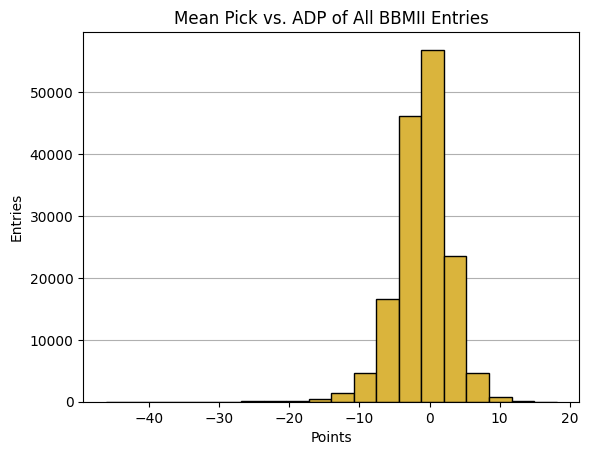

In [19]:
plt.hist(df_merged['vs_adp'],
         color='#DAB43C',
         edgecolor='black',
         bins=20)

ax1 = plt.subplot()

ax1.grid(axis='y')
ax1.set_axisbelow(True)
plt.title('Mean Pick vs. ADP of All BBMII Entries')
plt.xlabel('Points')
plt.ylabel('Entries')

plt.show()

It looks like the *vs_adp* column is roughly normally distrubuted with a few outliers, including one extremely low outlier at -46.14. This means that one entry somehow managed to draft 46.14 picks ahead of ADP on average. Whoever drafted this team was really reaching for players. Most entries tend to balance out, with the IQR being between -3.02 and 1.36.

In [20]:
df_merged['stacked_players'].describe()

count    155375.000000
mean          8.599517
std           2.557356
min           0.000000
25%           7.000000
50%           9.000000
75%          10.000000
max          18.000000
Name: stacked_players, dtype: float64

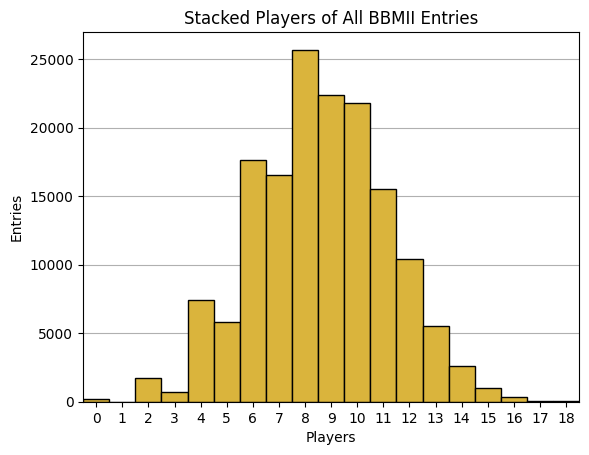

In [21]:
plt.hist(df_merged['stacked_players'],
         color='#DAB43C',
         edgecolor='black',
         bins=np.arange(20)-0.5)

ax1 = plt.subplot()

plt.xticks(np.arange(19))
ax1.grid(axis='y')
ax1.set_axisbelow(True)
plt.xlim([-0.5, 18.5])
plt.title('Stacked Players of All BBMII Entries')
plt.xlabel('Players')
plt.ylabel('Entries')

plt.show()

*stacked_players* appears to be distributed normally as well, with entries containing 8.60 stacked players on average. Only a small handful of entries had 0 stacks (and therefore 0 stacked players), with some entries having every player on their roster techincally part of a stack (18 stacked players).

Text(0, 0.5, '')

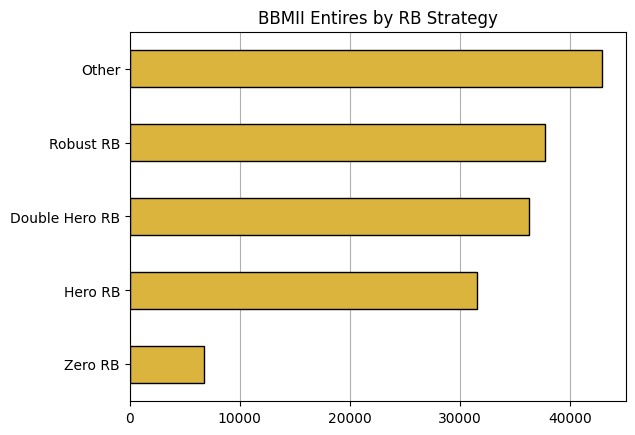

In [23]:
strategy_counts = pd.DataFrame(df_merged.groupby(['strategy'])['strategy'].count())
strategy_counts.columns = ['count']
strategy_counts = strategy_counts.reset_index()
strategy_counts = strategy_counts.sort_values(by=['count'], ascending=True)

ax1 = plt.subplot()

fig=strategy_counts.plot.barh(x='strategy',
                              y='count',
                              ax=ax1,
                              color='#DAB43C',
                              edgecolor='black',
                              legend=False)

ax1.grid(axis='x')
ax1.set_axisbelow(True)
fig.set_title('BBMII Entires by RB Strategy')
fig.axes.set_ylabel('')

Many entires could not be classified into one of our defined early round RB strategies, but the most commonly used strategy was Robust RB with nearly 40,000 entries. Zero RB held up the rear with less than 10,000 entries utilizing this approach.

In [24]:
df_merged['roster_points'].describe()

count    155375.000000
mean       1534.633074
std         136.716034
min         832.320000
25%        1444.280000
50%        1536.540000
75%        1626.820000
max        2225.440000
Name: roster_points, dtype: float64

Text(0, 0.5, 'Entries')

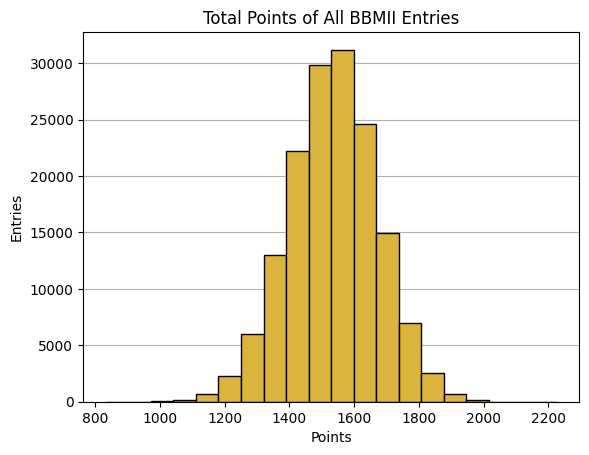

In [25]:
plt.hist(df_merged['roster_points'],
         color='#DAB43C',
         edgecolor='black',
         bins=20)

ax1 = plt.subplot()

plt.grid(axis='y')
ax1.set_axisbelow(True)
plt.title('Total Points of All BBMII Entries')
plt.xlabel('Points')
plt.ylabel('Entries')

Again, we see another normally distributed variable with *roster_points*. The average was 1534.63 and entires deviated from the mean, on average, by 136.72. Hats off to the team that scored an absurd 2225.44 points!

Now we can shift our focus to our model. Before we start, we'll need to convert the *strategy* column to a numeric data type through one-hot encoding.

In [26]:
df_final = pd.get_dummies(df_merged)

df_final.head()

,roster_points,vs_adp,stacked_players,strategy_Double Hero RB,strategy_Hero RB,strategy_Other,strategy_Robust RB,strategy_Zero RB
0,1657.94,-1.528333,10,0,0,1,0,0
1,1702.66,2.229444,7,0,0,0,1,0
2,1660.74,0.882778,4,0,1,0,0,0
3,1622.50,-4.010556,8,0,1,0,0,0
4,1511.16,4.140000,7,0,0,1,0,0


Next, we need to split our data into a training and testing set. We'll be using an 80/20 split.

In [27]:
from sklearn.model_selection import train_test_split

X = df_final[['vs_adp', 'stacked_players', 'strategy_Double Hero RB', 'strategy_Hero RB', 'strategy_Other', 'strategy_Robust RB', 'strategy_Zero RB']]
y = df_final['roster_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

XGBoost, or Extreme Gradient Boosting, is a boosting algorithm that utilizes decision trees and ensemble learning. Multiple models (decision trees) are created, each producing different degrees of errors. When subsequent models are created, they improve the predictions of prior models and ultimately combine to produce an optimized model. This makes XGBoost great at minimizing bias and reducing training error. Futhermore, XGBoost internally handles missing values, uses cross validation, and has parallel processing. It's efficient, accurate, and easy to use, making it one of the most popular and widely used machine learning algorithms today.

We'll be using an XGBoost model with a learning rate of 0.1 and 200 trees, leaving all other hyperparameters to be tuned.

In [29]:
xgbr = XGBRegressor(learning_rate=0.1,
                    n_estimators=200)

Now that we've created our initial model, we'll tune our desired hyperparameters. Using a grid search to do this would drastically increase training time, so we'll use a randomized search instead. This will find the best hyperparameters for 50 random combinations out of 320 possible combinations.

In [31]:
parameters = {'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 2, 5, 10],
              'gamma': [0, 0.5, 1, 1.5, 2],
              'subsample': [0.7, 0.8, 0.9, 1.0]}

model = RandomizedSearchCV(xgbr,
                           param_distributions=parameters,
                           n_iter=50,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=5,
                           verbose=0,
                           random_state=123)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:1387.54331	validation_1-rmse:1387.01459
[1]	validation_0-rmse:1250.18026	validation_1-rmse:1249.65866
[2]	validation_0-rmse:1126.70453	validation_1-rmse:1126.18609
[3]	validation_0-rmse:1015.74318	validation_1-rmse:1015.22077
[4]	validation_0-rmse:916.06278	validation_1-rmse:915.54023
[5]	validation_0-rmse:826.55440	validation_1-rmse:826.02993
[6]	validation_0-rmse:746.22198	validation_1-rmse:745.68575
[7]	validation_0-rmse:674.17053	validation_1-rmse:673.62724
[8]	validation_0-rmse:609.59642	validation_1-rmse:609.03943
[9]	validation_0-rmse:551.77800	validation_1-rmse:551.20431
[10]	validation_0-rmse:500.06727	validation_1-rmse:499.48112
[11]	validation_0-rmse:453.87991	validation_1-rmse:453.27764
[12]	validation_0-rmse:412.69585	validation_1-rmse:412.07765
[13]	validation_0-rmse:376.04375	validation_1-rmse:375.40579
[14]	validation_0-rmse:343.49877	validation_1-rmse:342.84177
[15]	validation_0-rmse:314.67897	validation_1-rmse:313.99700
[16]	validation_0-rmse:289

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=200, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.5, 1, 1.5, 2],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 2, 5, 10],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=123, scoring='neg_root_mean_squared_error')

In [32]:
print('\nBest hyperparameters:')
print(model.best_params_)


Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 0}


Based on the results of the randomized serach, these are the best values for each hyperparameter. We'll re-train our model with these hyperparameter values.

In [35]:
xgbr = XGBRegressor(learning_rate=0.1,
                    n_estimators=200,
                    subsample=1.0,
                    min_child_weight=5,
                    max_depth=3,
                    gamma=0,
                    verbosity=0)

xgbr.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

y_pred = model.predict(X_test)

results = xgbr.evals_result()

In [36]:
from sklearn.metrics import mean_squared_error

min_rmse = min(results['validation_1']['rmse'])
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('Minimum Test RMSE:  %.2f' % min_rmse)
print('Actual Test RMSE:  %.2f' % rmse)

Minimum Test RMSE:  133.74
Actual Test RMSE:  133.77


The RMSE (root mean squared error) for the test set was 133.77. Although overfitting isn't a major concern with XGBoost in the first place, we can see that the the lowest possible RMSE is only 0.03 less than our actual RMSE, ensuring that we didn't overfit the model.

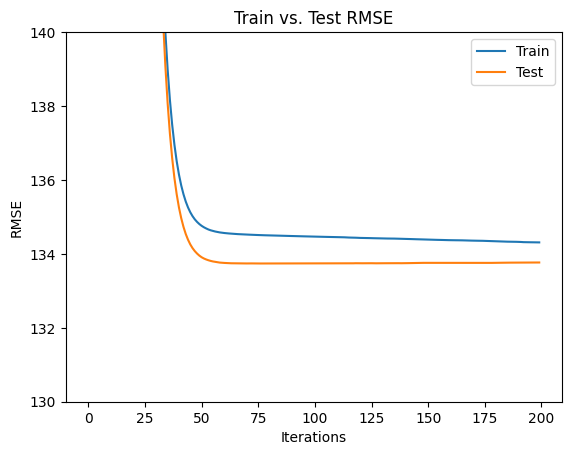

In [37]:
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')

plt.legend()
plt.ylim([130, 140])
plt.title('Train vs. Test RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show()

Since MAE (mean absolute error) is easier to interpret, we'll also print the MAE of our model.

In [38]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)

print('MAE: %.2f' % mae)

MAE: 106.30


Based on the MAE, we can say our model was off by 106.30 points on average.

Our model was somewhat accurate. 106.30 points can be substantial when it comes to Best Ball Mania; That might be the difference between an entry that finishes 1st in its group and an entry that finishes 5th. That being said, fantasy football is full of unpredictability and there's definitely more to drafting than just ADP, stacking, and early round RB strategy. Nevertheless, it is interesting to see how we can predict, with decent accuracy, how many points a Best Ball Mania entry will score based soley on these factors.